In [16]:
import os
import pandas as pd



In [17]:
_HERE = ''
data_path = join(_HERE, '..', '..', 'dataset', 'movielens')

movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'

In [18]:
# read data
df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),

    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [19]:
df_movies.head()
df_movies.shape

(62423, 2)

In [20]:
df_ratings.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [22]:
df_ratings = df_ratings[:2000000]
df_ratings.shape

(2000000, 3)

In [23]:
from scipy.sparse import csr_matrix

# pivot ratings into movie features
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [24]:
mat_movie_features = csr_matrix(df_movie_features.values)

In [25]:
df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,13313,13314,13315,13316,13317,13318,13319,13320,13321,13322
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,4.0,0.0,0.0,4.0,0.0,3.5,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [27]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())

print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 13322 unique users and 27321 unique movies in this data set


In [28]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,30398
1.0,61286
1.5,32659
2.0,131126
2.5,100189
3.0,390617
3.5,251597
4.0,533326
4.5,175316


In [29]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,361970362
0.5,30398
1.0,61286
1.5,32659
2.0,131126
2.5,100189
3.0,390617
3.5,251597
4.0,533326
4.5,175316


In [30]:
# log normalise to make it easier to interpret on a graph
import numpy as np

df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,361970362,19.707073
0.5,30398,10.322132
1.0,61286,11.023307
1.5,32659,10.393876
2.0,131126,11.783914
2.5,100189,11.514814
3.0,390617,12.875483
3.5,251597,12.435584
4.0,533326,13.186888
4.5,175316,12.074345


Text(0, 0.5, 'number of ratings')

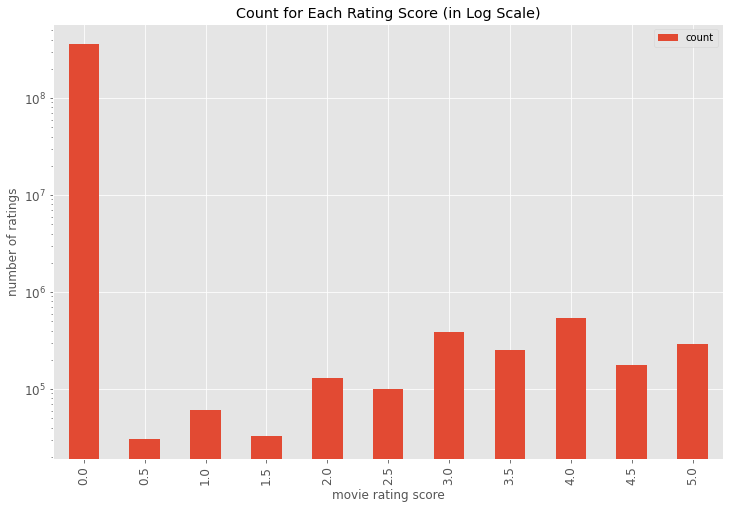

In [31]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [32]:
# get rating frequency
# number of ratings each movie got.
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,4696
2,1931
3,953
4,189
5,965


In [34]:
#now we need to take only movies that have been rated at least 50 times to get some idea 
#of the reactions of users towards it

popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]

print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping unpopular movies:  (1845227, 3)


In [35]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,51
2,180
3,644
4,235
5,101


In [36]:
# filter data to come to an approximation of user likings.
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]

print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (1685234, 3)


In [37]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)

#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}

# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [38]:
movie_user_mat_sparse

<4870x8170 sparse matrix of type '<class 'numpy.float32'>'
	with 1685234 stored elements in Compressed Sparse Row format>

In [39]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [41]:
from fuzzywuzzy import fuzz

/opt/conda/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [42]:
def fuzzy_matching(movie_names, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    the closest match
    """
    match_tuple = []
    # get match
    for title in movie_names:
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[-1])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][0]

In [43]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [44]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Dark Knight Rises, The (2012), with distance of 0.4119985103607178
2: Guardians of the Galaxy (2014), with distance of 0.41174548864364624
3: Inception (2010), with distance of 0.39818328619003296
4: Star Trek (2009), with distance of 0.3970410227775574
5: WALL·E (2008), with distance of 0.39148426055908203
6: Avatar (2009), with distance of 0.38175857067108154
7: Batman Begins (2005), with distance of 0.37104135751724243
8: Iron Man 2 (2010), with distance of 0.37047940492630005
9: Avengers, The (2012), with distance of 0.34962183237075806
10: Dark Knight, The (2008), with distance of 0.2952839136123657
